### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

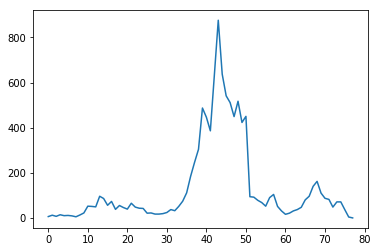

In [41]:
import numpy as np
import matplotlib.pyplot as plt


n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "30":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
#np.set_printoptions(threshold=np.nan)

plt.plot(reporting_matrix.sum(axis=1))
plt.show()

78
0.03652777777777778


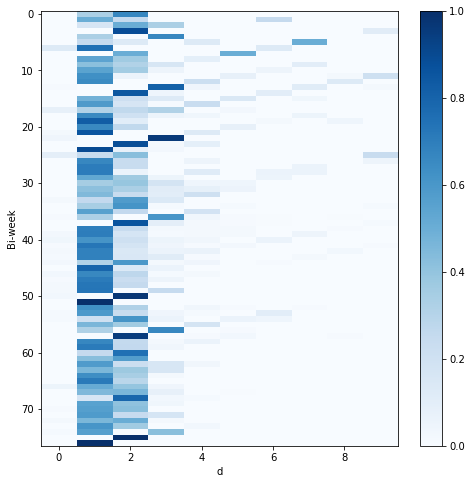

In [42]:
print (len(reporting_matrix))
D=10
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d[:-1]
p_hat = []

from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat.append(n_t_d[i]/np.sum(n_t_d[i]))
    
p_hat = np.array(p_hat)
print (np.var(p_hat[:2]))
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


[5.4415511e-03 8.0948705e-03 7.9393098e-03 1.4243479e-02 6.2946659e-03
 0.0000000e+00 6.7309031e-07 0.0000000e+00 0.0000000e+00 4.2829183e-07]


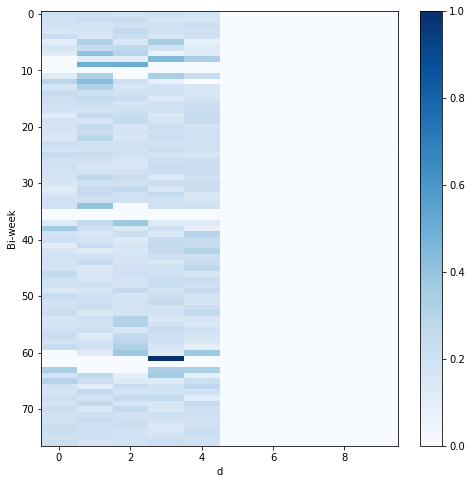

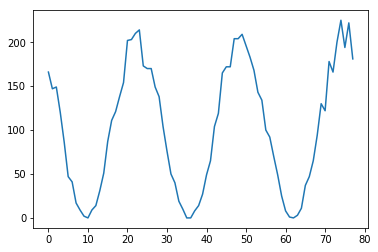

In [51]:
# list for holding simulated data, length 260
arr_list = np.zeros(260)
# iterate over season  
for s in range(10):
    #iterate over biweek per season
    for t in range(26):
        season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
        e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
        arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 

# plot simulated data to make sure it looks like ID        
ts = arr_list[:100]

p_vec = np.random.dirichlet(np.append(10000*np.ones(5),np.ones(D-5)),size=1)[0]

sim_n_t_d = []
for i in range(78):
    tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)    
    
p_hat_sim = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat_sim.append(sim_n_t_d[i]/np.sum(sim_n_t_d[i]))
    
p_hat_sim = np.nan_to_num(np.array(p_hat_sim))

print (np.var(p_hat_sim,axis=0))
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(sim_n_t_d.sum(axis=1))
plt.show()

In order to simulate delayed data we first randomly simualte the delay proportions from a dirichlet distribution

If the true delay distribution is given by 
$$p_0,...,p_{9} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

we can interpret $p_i$ as the percentage of cases that were delayed by $i$ days.

In [52]:
import emcee
from scipy.stats import binom
from scipy.stats import norm
import pymc3 as pm

def bayes_estimate(p_vec,process,process_var,partially_observed,scale_factor):
    basic_model = pm.Model()

    with basic_model:

        # Priors for unknown model parameters
        n_t_inf = pm.Normal('n_t_inf', mu=process, sd=np.sqrt(process_var)/scale_factor)


        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Binomial('Y_obs', n=n_t_inf, p=sum(p_vec), observed=sum(partially_observed))
    map_estimate = pm.find_MAP(model=basic_model)
    return map_estimate['n_t_inf']

/Users/gcgibson/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


260


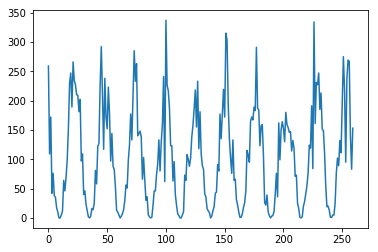

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in divide


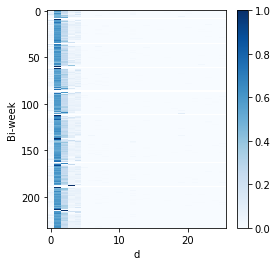

model 2
[149.   110.09  54.06  19.03  20.04  13.03   1.     1.     5.02   5.02
  26.11  77.34 102.52  89.48 133.03 111.88 197.6  273.28 216.13  96.13
 238.95 270.48 264.12 142.56  90.85 196.34]
model 1
[149.   110.09  54.06  19.03  20.04  13.03   1.     1.     5.02   5.02
  26.11  77.34 102.52  89.48 133.03 111.88 197.6  273.28 216.13  96.13
 238.95 270.48 264.12 142.56  90.85 196.34]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]


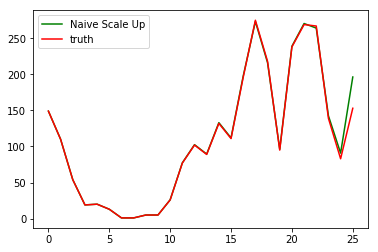

------
1878.3556000000003
1878.3556000000003


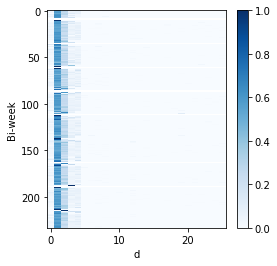

model 2
[149.   110.1   54.07  19.04  20.04  13.04   1.     1.     5.02   5.02
  26.11  77.35 102.53  89.49 133.   111.85 197.56 273.19 216.07  96.09
 238.86 270.38 263.95 142.73  90.88 195.34]
model 1
[149.   110.1   54.07  19.04  20.04  13.04   1.     1.     5.02   5.02
  26.11  77.35 102.53  89.49 133.   111.85 197.56 273.19 216.07  96.09
 238.86 270.38 263.95 142.73  90.88 195.34]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]


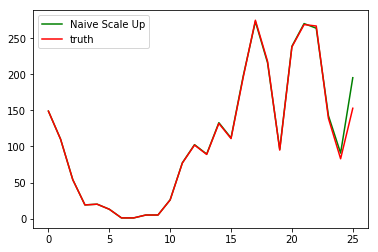

------
1792.6756000000003
1792.6756000000003


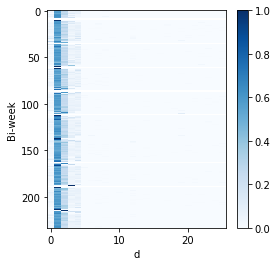

model 2
[149.   110.09  54.06  19.03  20.05  13.04   1.     1.     5.02   5.02
  26.12  77.38 102.56  89.51 133.06 111.91 197.64 273.32 216.16  96.14
 238.98 270.51 264.67 143.08  91.24 196.74]
model 1
[149.   110.09  54.06  19.03  20.05  13.04   1.     1.     5.02   5.02
  26.12  77.38 102.56  89.51 133.06 111.91 197.64 273.32 216.16  96.14
 238.98 270.51 264.67 143.08  91.24 196.74]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]


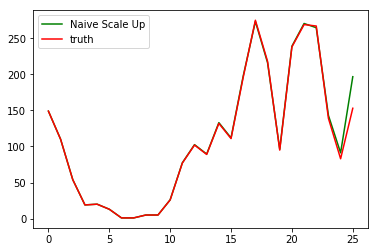

------
1913.1876000000009
1913.1876000000009


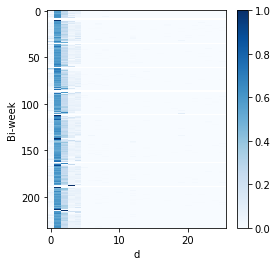

model 2
[149.   110.1   54.07  19.03  20.05  13.04   1.     1.     5.02   5.02
  26.13  77.38 102.58  89.52 133.09 111.93 197.69 273.41 216.21  96.15
 239.01 270.56 264.57 142.97  90.8  198.49]
model 1
[149.   110.1   54.07  19.03  20.05  13.04   1.     1.     5.02   5.02
  26.13  77.38 102.58  89.52 133.09 111.93 197.69 273.41 216.21  96.15
 239.01 270.56 264.57 142.97  90.8  198.49]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]


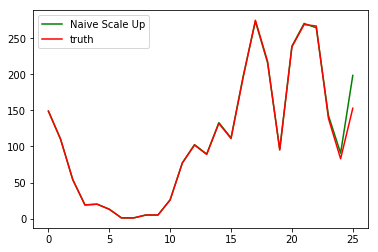

------
2069.340100000001
2069.340100000001


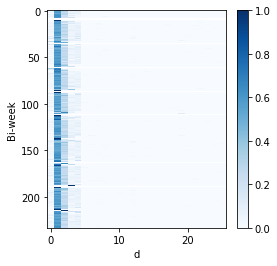

model 2
[149.   110.09  54.06  19.03  20.04  13.03   1.     1.     5.02   5.02
  26.12  77.36 102.54  89.5  133.05 111.9  197.63 273.32 216.17  96.15
 238.99 270.51 264.36 142.75  90.84 196.18]
model 1
[149.   110.09  54.06  19.03  20.04  13.03   1.     1.     5.02   5.02
  26.12  77.36 102.54  89.5  133.05 111.9  197.63 273.32 216.17  96.15
 238.99 270.51 264.36 142.75  90.84 196.18]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]


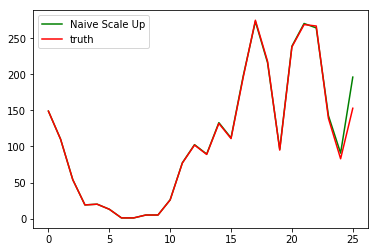

------
1864.5124000000005
1864.5124000000005


KeyboardInterrupt: 

In [27]:
from scipy.special import expit
import matplotlib.pyplot as plt
np.random.seed(1)

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

D = 26
arr_list = np.zeros(260)
        # iterate over season  
        #iterate over biweek per season
r=10
for t in range(260):
            season_effect = 10#np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[t] = np.random.negative_binomial(r,r/(r+10*e_y))
    # plot simulated data to make sure it looks like ID        
ts =arr_list#[16:len(arr_list)-10]
print (len(ts))
plt.plot(ts)
plt.show()

p_vec_1 = p_vec = np.random.dirichlet(np.append(10000*np.ones(5),np.ones(D-5)),size=1)[0]
p_vec_2 = np.random.dirichlet(np.append([50,400,1000,100,100],np.ones(D-5)),size=1)[0]
p_vec_3 = np.random.dirichlet(np.append([50,400,500,1000,100],np.ones(D-5)),size=1)[0]
p_vec_list = [p_vec_1,p_vec_2,p_vec_3]

sim_n_t_d = []
for i in range(len(ts)):
    tmp1 = np.random.multinomial(ts[i],p_vec_list[0],size=D).tolist()[0]
    tmp2 = np.array(tmp1)
    sim_n_t_d.append(tmp2.tolist() )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)


sim_n_t_d = sim_n_t_d.reshape((-1,26,D))

rmse_vec = []
#iterate over all 10 seasons doing a leave one season out
for var in np.arange(10):
    season_for_leave_out = var
    train = [sim_n_t_d[x] for x in range(10) if x not in [season_for_leave_out]]
    test = sim_n_t_d[season_for_leave_out]
    
    
    train = np.array(train)
    train_n_t_d = train.reshape((-1,D))
    ts = train_n_t_d.sum(axis=1)
    data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]
    
    p_hat_sim = []
    from matplotlib.pyplot import cm

    for i in range(len(train_n_t_d)):
        p_hat_sim.append(train_n_t_d[i]/np.sum(train_n_t_d[i]))


    plt.figure(figsize=(4,4))
    plt.ylabel("Bi-week")
    plt.xlabel("d")
    plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
    plt.legend()
    plt.colorbar()
    plt.show()

    
    
    delayed_data = []
    count = D
    for i in range(len(data_to_be_scaled_down)):
        tmp = data_to_be_scaled_down[i][:count].tolist()
        while len(tmp) <D:
            tmp.append(0)
        delayed_data.append(tmp)
        count -=1 
    
    
    training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

    k = np.array(train_n_t_d).shape[1 ]
    p_vec_noise = np.ones(k)

    for i in range(len(ts)-D):
        p_vec_noise += train_n_t_d[i]

    p_vec_noise = p_vec_noise/np.sum(p_vec_noise)
    #### training data is all set
    
    ###filling in ps model 1
    model_1_delay = []
    count = D
    for i in range(len(delayed_data)):
        delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
        model_1_delay.append(np.round(delay_forecast,2))
        count -= 1
    model_1_delay = np.array(model_1_delay)
    
    
    
   
    
    model_2_delay = []
    count = D
    
    for i in range(len(delayed_data)):
        delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])       
        model_2_delay.append(np.round(delay_forecast,2))
        count -= 1
    model_2_delay = np.array(model_2_delay)
   
    print ("model 2")
    print (model_2_delay)
    print ("model 1")
    print (model_1_delay)
    print ("truth")
    print (ts[len(ts)-D:])
    #plt.plot(model_2_delay,color='b')
    plt.plot(model_1_delay,color='g')
    plt.plot(ts[len(ts)-D:],color='r')
    plt.legend(("Naive Scale Up","truth"))
    plt.show()
    #print ("process model")
    #print (process_model_forecast)
    
    ###filling in ps
    print ("------")
    cut_blah = 25
    print (mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    print (mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    rmse_vec.append(mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:])/mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    
    
        
        
        